<img title="GitHub Octocat" src='./img/Octocat.jpg' style='height: 60px; padding-right: 15px' alt="Octocat" align="left"> This notebook is part of a GitHub repository: https://github.com/pessini/moby-bikes 
<br>MIT Licensed
<br>Author: Leandro Pessini

<img title="Moby Bikes" src="https://i.ytimg.com/vi/-s8er6tHD3o/maxresdefault.jpg" style="height:400px; border-radius: 10px" alt="Moby Bikes" class="img-fluid">

<div class="list-group" id="list-tab" role="tablist">
  <h1 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home">&nbsp;Table of Contents:</h1>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#1" role="tab" aria-controls="profile">1. Introduction<span class="badge badge-primary badge-pill">1</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#2" role="tab" aria-controls="messages">2. Feature Engineering<span class="badge badge-primary badge-pill">2</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#3" role="tab" aria-controls="messages">3. EDA (Exploratory Data Analysis)<span class="badge badge-primary badge-pill">3</span></a>
   <a class="list-group-item list-group-item-action" data-toggle="list" href="#4" role="tab" aria-controls="messages">4. Model<span class="badge badge-primary badge-pill">4</span></a>
   <a class="list-group-item list-group-item-action" data-toggle="list" href="#5" role="tab" aria-controls="messages">5. Evaluation<span class="badge badge-primary badge-pill">5</span></a>    
   <a class="list-group-item list-group-item-action" data-toggle="list" href="#6" role="tab" aria-controls="messages">6. Conclusion<span class="badge badge-primary badge-pill">6</span></a>
</div>

---

<a id="1"></a>
# <p style="font-size:100%; text-align:left; color:#444444;">1- Introduction</p>

## Datasets

Dataset provided by [Moby Bikes](https://data.gov.ie/dataset/moby-bikes) through a public [API](https://data.smartdublin.ie/mobybikes-api). 

Dataset provided by [Met Éireann](https://www.met.ie/) through a public [API](https://data.gov.ie/organization/meteireann). 


The **aim** of this report is to map how this disease spread throughout the island and provide insights on possible spots and species that might need extra attention from the scientists who investigate this constant threat to resident birds.

## Questions

- What species have shown to be the most affected with Bird Flu?
- What are the most frequent locations where captured birds have been detected with Avian Flu?
- November is the month with the highest presence as mentioned? What are the months with the highest proportion of infected birds?
- The percentage of infected birds have increased during the years?
- What is the proportion of birds targeted with Avian Flu on each Council / County?
- Which areas present statistically significant incidence of Bird Flu?


>https://mobidev.biz/blog/machine-learning-methods-demand-forecasting-retail

In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [135]:
from conn import mongodb
import importlib
from pymongo import MongoClient
from urllib.parse import quote_plus
importlib.reload(mongodb)

<module 'conn.mongodb' from '/Users/pessini/Dropbox/Data-Science/moby-bikes/notebooks/conn/mongodb.py'>

In [136]:
def _connect_mongo(host, port, username, password, db_name):
    """ A util for making a connection to mongo """

    if username and password:
        try:
            mongo_uri = f'mongodb://{username}:{quote_plus(password)}@{host}:{port}/{db_name}'
            conn = MongoClient(mongo_uri)
        except:
            print('Could not connect to MongoDB')
    else:
        conn = MongoClient(host, port)

    return conn

In [137]:
def read_mongo(query={}, collection='', no_id=True):
    """ Read from Mongo and Store into a DataFrame """
    df = None
    try:
        # Connect to MongoDB
        conn = _connect_mongo(host=mongodb.host, port=mongodb.port, username=mongodb.user_name, password=mongodb.pass_word, db_name=mongodb.db_name)
        db = conn.mobybikes # switch to the database

        if collection in db.list_collection_names():
            
            # Make a query to the specific DB and Collection and store into a Dataframe
            data = db[collection].find(query)
            df =  pd.DataFrame(list(data))
            
            # Delete the _id
            if no_id:
                del df['_id']
        else:
            print(f'Collection {collection} was not found!')
            pass

        # close mongodb connection
        conn.close()
    except:
        print('Could not query MongoDB')
    
    return df


In [138]:
# from bson.objectid import ObjectId

# query = {
#     '_id': ObjectId('')
# }

historical_data = read_mongo(collection='historical')

In [139]:
historical_data.columns = historical_data.columns.str.lower()
historical_data.head()

,harvesttime,bikeid,battery,bikeidentifier,biketypename,ebikeprofileid,ebikestateid,isebike,ismotor,issmartlock,lastgpstime,lastrentalstart,latitude,longitude,spikeid
0,2021-04-01 00:00:03,5,7.0,1,DUB-General,1,2,True,False,False,2021-03-31 23:41:40,2021-03-30 19:18:18,53.3091,-6.21643,1
1,2021-04-01 00:00:03,6,16.0,2,DUB-General,1,2,True,False,False,2021-03-31 23:55:41,2021-03-31 10:31:13,53.3657,-6.32249,2
2,2021-04-01 00:00:03,7,66.0,3,DUB-General,4,2,True,False,False,2021-03-31 23:42:04,2021-03-30 13:07:19,53.2799,-6.14497,3
3,2021-04-01 00:00:03,8,48.0,4,DUB-General,1,2,True,False,False,2021-03-31 23:52:26,2021-03-30 12:43:17,53.2891,-6.11378,4
4,2021-04-01 00:00:03,9,-6.0,5,DUB-General,1,2,True,False,False,2021-03-31 23:50:20,2021-03-29 22:37:58,53.2928,-6.13014,5


In [140]:
historical_data.isnull().sum()

harvesttime            0
bikeid                 0
battery            29333
bikeidentifier         0
biketypename           0
ebikeprofileid         0
ebikestateid           0
isebike                0
ismotor                0
issmartlock            0
lastgpstime            0
lastrentalstart        0
latitude               0
longitude              0
spikeid                0
dtype: int64

## Weather Data - Met Éireann

About the weather data there are two important decisions. One is about from **which station** the **historical data will be collected** and the other one is about the **frequency of data**, which can be **hourly or daily**.

### Station Name: **PHOENIX PARK**

In [141]:
phoenixpark_weather_hourly = pd.read_csv('../data/raw/hly175.csv')
phoenixpark_weather_hourly.head()

,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl
0,16-aug-2003 01:00,0,0.0,0,9.2,0,8.9,8.5,11.1,95,1021.9
1,16-aug-2003 02:00,0,0.0,0,9.0,0,8.7,8.5,11.1,96,1021.7
2,16-aug-2003 03:00,0,0.0,0,8.2,0,8.0,7.7,10.5,96,1021.2
3,16-aug-2003 04:00,0,0.0,0,8.4,0,8.1,7.9,10.7,97,1021.2
4,16-aug-2003 05:00,0,0.0,0,7.7,0,7.5,7.3,10.2,97,1021.1


In [142]:
phoenixpark_weather_daily = pd.read_csv('../data/raw/dly175.csv')
phoenixpark_weather_daily.head()

,date,ind,maxtp,ind.1,mintp,igmin,gmin,ind.2,rain,cbl,soil
0,16-aug-2003,0,20.1,0,7.5,4,,0,0.0,1013.7,18.565
1,17-aug-2003,0,21.3,0,11.6,0,7.5,0,1.1,1007.5,18.280
2,18-aug-2003,0,20.3,0,8.5,0,4.3,0,0.0,1008.8,17.825
3,19-aug-2003,0,19.9,0,11.3,0,7.7,0,0.0,1014.3,18.138
4,20-aug-2003,0,21.5,0,10.8,0,6.9,0,0.0,1013.6,18.432


### Station Name: **DUBLIN AIRPORT**

In [143]:
dublin_airport_weather_hourly = pd.read_csv('../data/raw/hly532.csv')
dublin_airport_weather_hourly.head()

,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,...,ind.3,wdsp,ind.4,wddir,ww,w,sun,vis,clht,clamt
0,01-jan-2020 00:00,0,0.0,0,6.9,0,5.7,4.1,8.2,82,...,2,4,2,220,2,11,0.0,25000,22,7
1,01-jan-2020 01:00,0,0.0,0,6.9,0,5.5,3.7,7.9,80,...,2,4,2,230,2,11,0.0,20000,30,7
2,01-jan-2020 02:00,0,0.0,0,6.3,0,4.7,2.4,7.3,76,...,2,6,2,230,2,11,0.0,20000,28,7
3,01-jan-2020 03:00,3,0.0,0,4.7,0,3.6,2.0,7.0,82,...,2,4,2,230,2,11,0.0,15000,999,3
4,01-jan-2020 04:00,3,0.0,0,0.6,0,0.1,-0.7,5.8,90,...,2,3,2,150,2,11,0.0,15000,999,1


## Phoenix Park Station vs Dublin Aiport Station
Geographically, the station at Phoenix Park would be the most suitable choice but unfortunately, they do not collect Wind information which in Ireland plays an important role when deciding to go cycling or not. For those who are not familiar with Irish weather, it rains a lot and mostly we do not have much choice about it but the wind is something that can prevent you go outside or choose a different kind of transport. Heavy rain is kind of rare on the other hand.

## Hourly vs Daily data
On this subject, daily data for the business would make more sense but because the weather is so unpredictable in Ireland (it can completely change in an hour), the best option would be hourly especially if we are looking at a historical perspective. For simplicity and better planning, we can always aggregate the predicted results by day.

In [144]:
dublin_airport_weather_hourly['date'] = pd.to_datetime(dublin_airport_weather_hourly['date'])

In [145]:
dublin_airport_weather_hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13873 entries, 0 to 13872
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    13873 non-null  datetime64[ns]
 1   ind     13873 non-null  int64         
 2   rain    13873 non-null  float64       
 3   ind.1   13873 non-null  int64         
 4   temp    13873 non-null  float64       
 5   ind.2   13873 non-null  int64         
 6   wetb    13873 non-null  float64       
 7   dewpt   13873 non-null  float64       
 8   vappr   13873 non-null  float64       
 9   rhum    13873 non-null  int64         
 10  msl     13873 non-null  float64       
 11  ind.3   13873 non-null  int64         
 12  wdsp    13873 non-null  int64         
 13  ind.4   13873 non-null  int64         
 14  wddir   13873 non-null  int64         
 15  ww      13873 non-null  int64         
 16  w       13873 non-null  int64         
 17  sun     13873 non-null  float64       
 18  vis   

In [146]:
dublin_airport_weather_hourly.tail()

,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,...,ind.3,wdsp,ind.4,wddir,ww,w,sun,vis,clht,clamt
13868,2021-07-31 20:00:00,2,0.0,0,15.3,0,13.9,12.8,14.8,85,...,2,3,2,280,50,52,0.0,30000,20,7
13869,2021-07-31 21:00:00,0,0.4,0,14.2,0,13.6,13.2,15.1,93,...,2,6,2,340,60,65,0.0,6000,18,7
13870,2021-07-31 22:00:00,0,0.2,0,13.5,0,13.1,12.7,14.7,95,...,2,3,2,310,60,62,0.0,6000,42,7
13871,2021-07-31 23:00:00,2,0.0,0,13.1,0,12.1,11.2,13.3,88,...,2,4,2,340,21,62,0.0,20000,31,7
13872,2021-08-01 00:00:00,0,0.0,0,12.6,0,11.4,10.3,12.5,86,...,2,6,2,310,2,65,0.0,20000,32,7


In [147]:
recent_dubairport_data = dublin_airport_weather_hourly.copy()

start_date_hist = datetime(2020, 9, 23) # first day registered
end_date_hist = datetime(2021, 7, 31) # last day used as historical data

recent_dubairport_data = recent_dubairport_data[(recent_dubairport_data.date >= start_date_hist) & (recent_dubairport_data.date <= end_date_hist)]

In [148]:
len(dublin_airport_weather_hourly), len(recent_dubairport_data)

(13873, 7465)

In [149]:
columns_to_drop = ['ind','ind.1','ind.2','ind.3','vappr','msl','ind.4','wddir','ww','w','sun','vis','clht','clamt']
weather_data = recent_dubairport_data.drop(columns=columns_to_drop)
weather_data.to_csv('../data/interim/hist_weather_data.csv')

In [150]:
weather_data.head()

,date,rain,temp,wetb,dewpt,rhum,wdsp
6384,2020-09-23 00:00:00,0.1,10.5,10.0,9.4,94,10
6385,2020-09-23 01:00:00,0.0,9.4,9.1,8.7,96,7
6386,2020-09-23 02:00:00,0.0,8.8,8.5,8.2,96,7
6387,2020-09-23 03:00:00,0.0,8.6,8.3,8.0,96,7
6388,2020-09-23 04:00:00,0.0,8.9,8.5,8.0,95,8


## Hypothesis

Hourly trend: There must be high demand during office timings. Early morning and late evening can have different trend (cyclist) and low demand during 10:00 pm to 4:00 am.

Daily Trend: Registered users demand more bike on weekdays as compared to weekend or holiday.

Rain: The demand of bikes will be lower on a rainy day as compared to a sunny day. Similarly, higher humidity will cause to lower the demand and vice versa.

Temperature: In Ireland, temperature has positive correlation with bike demand.

Time: Total demand should have higher contribution of registered user as compared to casual because registered user base would increase over time.

Traffic: It can be positively correlated with Bike demand. Higher traffic may force people to use bike as compared to other road transport medium like car, taxi etc.



<a id="2"></a>
# <p style="font-size:100%; text-align:left; color:#444444;">2- Feature Engineering</p>

### New Features
- date (yyyy-mm-dd)
- month
- hour
- workingday
- peak
- holiday
- season
- battery_start
- battery_end
- path? (multi polygon)
- rental_duration


The number of rentals each hour will be aggregate later with a new feature `count`.

In [151]:
rentals_data = historical_data.drop(['harvesttime','ebikestateid'], axis=1).copy()
rentals_data[["lastgpstime", "lastrentalstart"]] = rentals_data[["lastgpstime", "lastrentalstart"]].apply(pd.to_datetime)

rentals_data = rentals_data.astype({'battery': np.int16}, errors='ignore') # errors ignore to keep missing values (not throwing error)

In [152]:
rentals_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149281 entries, 0 to 1149280
Data columns (total 13 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   bikeid           1149281 non-null  object        
 1   battery          1119948 non-null  object        
 2   bikeidentifier   1149281 non-null  object        
 3   biketypename     1149281 non-null  object        
 4   ebikeprofileid   1149281 non-null  object        
 5   isebike          1149281 non-null  object        
 6   ismotor          1149281 non-null  object        
 7   issmartlock      1149281 non-null  object        
 8   lastgpstime      1149281 non-null  datetime64[ns]
 9   lastrentalstart  1149281 non-null  datetime64[ns]
 10  latitude         1149281 non-null  object        
 11  longitude        1149281 non-null  object        
 12  spikeid          1149281 non-null  object        
dtypes: datetime64[ns](2), object(11)
memory usage: 114.0+ MB


### Rentals' information

- `coordinates`: converting latitude and longitude to an array to store a GeoJSON object *MultiPoint* 
- `start_battery`: getting the battery status when the rental started
- `lastgpstime`: new variable that will only store the last record when grouping rentals

In [153]:
def feat_eng(x):
    d = {}
    d['coordinates'] = x[['latitude','longitude']].values.tolist()
    d['start_battery'] = list(x['battery'])[-1] # get the first battery status (when rental started)
    d['lastgpstime'] = list(x['lastgpstime'])[0] # get the last gpstime (previously sorted)
    
    return pd.Series(d, index=['coordinates', 'start_battery', 'lastgpstime'])

# also sorting data by lastgpstime
grouped_rentals = rentals_data.sort_values("lastgpstime", ascending=False).groupby(['lastrentalstart', 'bikeid']).apply(feat_eng).reset_index()

In [154]:
grouped_rentals.shape

(33721, 5)

### Date and time - new features
- `rental_date`
- `rental_month`
- `rental_hour`
- `holiday`
- `workingday`
- `season`: (1 = Spring, 2 = Summer, 3 = Fall, 4 = Winter)
- *`duration`: duration of the rental

\* **Assumption**: that the duration of the rental is $ LastGPSTime - RentalStart $

In [155]:
grouped_rentals['rental_date'] = pd.to_datetime(grouped_rentals['lastrentalstart'].dt.date)
grouped_rentals['rental_month'] = grouped_rentals['lastrentalstart'].dt.month
grouped_rentals['rental_hour'] = grouped_rentals['lastrentalstart'].dt.hour

In [156]:
grouped_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33721 entries, 0 to 33720
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   lastrentalstart  33721 non-null  datetime64[ns]
 1   bikeid           33721 non-null  object        
 2   coordinates      33721 non-null  object        
 3   start_battery    33087 non-null  object        
 4   lastgpstime      33721 non-null  datetime64[ns]
 5   rental_date      33721 non-null  datetime64[ns]
 6   rental_month     33721 non-null  int64         
 7   rental_hour      33721 non-null  int64         
dtypes: datetime64[ns](3), int64(2), object(3)
memory usage: 2.1+ MB


In [157]:
# time of rental in minutes (lastgpstime - rental-start)
grouped_rentals['duration'] = (grouped_rentals['lastgpstime'] - grouped_rentals['lastrentalstart']) / pd.Timedelta(minutes=1)

A few GPS records have frozen and stopped sending the accurate data back. About 345 records which would lead to a bias duration of rentals.

To prevent any inaccurate information these records will be set as `NaN`.

In [158]:
grouped_rentals['duration'] = np.where(grouped_rentals['duration'] < 0, np.NaN, grouped_rentals['duration'])
len(grouped_rentals[ np.isnan(grouped_rentals['duration']) ])

365

## Bank Holidays

In [159]:
qry_bh = {
    'type': 'National holiday'
}

bank_holidays = read_mongo(query=qry_bh, collection='irishcalendar')
bank_holidays.drop(['country', 'type'], axis=1, inplace=True)
bank_holidays['date'] = pd.DatetimeIndex(bank_holidays['date'].apply(pd.to_datetime))

In [160]:
# holiday
grouped_rentals['holiday'] = grouped_rentals['rental_date'].isin(bank_holidays['date'])

# day of the week
grouped_rentals['dayofweek'] = grouped_rentals['rental_date'].dt.dayofweek

# working day (Monday=0, Sunday=6)
grouped_rentals['working_day'] = grouped_rentals['dayofweek'] < 5 # from 0 to 4 or monday to friday

## Seasons

In [161]:
Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [(3, (datetime(Y,  1,  1),  datetime(Y,  3, 20))),
           (0, (datetime(Y,  3, 21),  datetime(Y,  6, 20))),
           (1, (datetime(Y,  6, 21),  datetime(Y,  9, 22))),
           (2, (datetime(Y,  9, 23),  datetime(Y, 12, 20))),
           (3, (datetime(Y, 12, 21),  datetime(Y, 12, 31)))]

def get_season(date: pd.DatetimeIndex) -> int:
    '''
        Receives a date and returns the corresponded season
        0 - Spring | 1 - Summer | 2 - Autumn | 3 - Winter
        Vernal equinox(about March 21): day and night of equal length, marking the start of spring
        Summer solstice (June 20 or 21): longest day of the year, marking the start of summer
        Autumnal equinox(about September 23): day and night of equal length, marking the start of autumn
        Winter solstice (December 21 or 22): shortest day of the year, marking the start of winter
    '''
    date = date.replace(year=Y)
    return next(season for season, (start, end) in seasons if start <= date <= end)


grouped_rentals['season'] = grouped_rentals.rental_date.map(get_season)

In [162]:
grouped_rentals.groupby('season').size()

season
0    9268
1    7175
2    9466
3    7812
dtype: int64

In [163]:
grouped_rentals.isnull().sum()

lastrentalstart      0
bikeid               0
coordinates          0
start_battery      634
lastgpstime          0
rental_date          0
rental_month         0
rental_hour          0
duration           365
holiday              0
dayofweek            0
working_day          0
season               0
dtype: int64

## Battery

In [164]:
grouped_rentals['start_battery'] = pd.to_numeric(grouped_rentals['start_battery'])

In [165]:
grouped_rentals[grouped_rentals['start_battery'] > 100]

,lastrentalstart,bikeid,coordinates,start_battery,lastgpstime,rental_date,rental_month,rental_hour,duration,holiday,dayofweek,working_day,season
18592,2021-04-03 12:40:00,103,"[[53.3405, -6.2679]]",268.0,2021-04-03 12:55:11,2021-04-03,4,12,15.183333,False,5,False,0


From the battery records there is a few cases that we can consider. Only one record has `> 100` and a few negatives ones. To simplify the analysis the records will be normalized with values between `0 > x > 100`.

All missing values (*n=571*) will not be transformed as it could be only malfunction issue when transmiting the data and it could mislead the analysis.

In [166]:
# normalize battery status between 0 > x < 100
grouped_rentals['start_battery'] = abs(grouped_rentals['start_battery'])
grouped_rentals.loc[grouped_rentals['start_battery'] > 100, 'start_battery'] = 100

In [167]:
new_rentals = grouped_rentals.copy()
new_rentals.to_csv('../data/interim/new_features_rentals.csv')

## Humidity

Attempt to create a new feature called `Humidity` to avoid Multicollinearity.

### We need different humidity quantities

The problem with relative humidity is that, by itself, it doesn’t really tell you how humid it is.

- **Relative Humidity** – This quantity tells us how close the conditions are to saturation, when condensation of water vapor can occur. The interaction of porous materials with water vapor increases with increasing RH. The chance of growing mold increases with increasing RH, 70% usually given as the threshold to stay below.
- **Dew Point Temperature** – This temperature scales with the amount of water vapor. As more water vapor enters a volume, the dew point goes up. If the air in your crawl space, for example, has a dew point of 75° F, you’re probably going to find condensation somewhere. Look at the water pipes, poorly insulated ducts, and uninsulated duct boots.
- **Wet Bulb Temperature** – If dew point is the temperature of condensation, wet bulb is the temperature of evaporation. Same concept; different direction. This one’s important for cooling our bodies.

Once you get a handle on these three quantities, you’ll have a pretty good understanding of humidity.

> https://www.energyvanguard.com/blog/problem-with-relative-humidity

In [168]:
weather_data.head()

,date,rain,temp,wetb,dewpt,rhum,wdsp
6384,2020-09-23 00:00:00,0.1,10.5,10.0,9.4,94,10
6385,2020-09-23 01:00:00,0.0,9.4,9.1,8.7,96,7
6386,2020-09-23 02:00:00,0.0,8.8,8.5,8.2,96,7
6387,2020-09-23 03:00:00,0.0,8.6,8.3,8.0,96,7
6388,2020-09-23 04:00:00,0.0,8.9,8.5,8.0,95,8


In [169]:
weather_data['rhum'] = pd.to_numeric(weather_data['rhum'],errors = 'coerce')
weather_data['wetb'] = pd.to_numeric(weather_data['wetb'],errors = 'coerce')
weather_data['dewpt'] = pd.to_numeric(weather_data['dewpt'],errors = 'coerce')

### Variance Inflation Factor(VIF)

In [170]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [171]:
test_vif = weather_data.copy().drop('date', axis=1)
#Calculate VIF for each variable in the new data frame
vif = pd.DataFrame()
vif["features"] = test_vif.columns
vif["vif_value"] = [variance_inflation_factor(test_vif.values, i) for i in range(test_vif.shape[1])]
vif

,features,vif_value
0,rain,1.119229
1,temp,1042.208290
2,wetb,2478.756183
3,dewpt,303.153508
4,rhum,7.595630
5,wdsp,5.618231


To avoid multicolinearity we could create a new feature based on some calculation on those three features related to humidity. Unfortunately, the Forecast API later that will be used in production to predict the demand **does not include Wet Bulb Temperature**.

There are a few equations that could applied to calculate Wet Bulb Temperature (eg: Stull formula) but because we do not have which one is used to store this feature on their historical the best would be not use this feature at all.

In [172]:
#weather_data.drop(['rhum', 'wetb', 'dewpt'], axis=1, inplace=True)

weather_data.drop(['wetb', 'dewpt'], axis=1, inplace=True)

## Combining Rentals and Weather data

In [173]:
rentals = new_rentals.copy()
weather = weather_data.copy()

weather['rental_date'] = pd.to_datetime(weather['date'].dt.date)
weather['rental_hour'] = weather['date'].dt.hour

## Peak Times

>https://www.independent.ie/irish-news/the-new-commuter-hour-peak-times-increase-with-record-traffic-volumes-36903431.html

In [175]:
rentals['peak'] = rentals[['rental_hour', 'working_day']].apply(lambda x: (0, 1)[(x['working_day'] == 1 and (6 <= x['rental_hour'] <= 10 or 15 <= x['rental_hour'] <= 19))], axis = 1)

In [176]:
all_data = pd.merge(rentals, weather, on=['rental_date', 'rental_hour'])
all_data.to_csv('../data/interim/all_data.csv')

<a id="3"></a>
# <p style="font-size:100%; text-align:left; color:#444444;">3- Exploratory Data Analysis (EDA)</p>

- Hourly trend
- Holiday
- Working_day
- Season

In [213]:
hourly_rentals = all_data.copy()
count_hourly_rentals = hourly_rentals.groupby(['rental_date', 'rental_hour']).size().reset_index(name='count')
columns_to_drop = ['lastrentalstart','bikeid','coordinates','start_battery','lastgpstime','rental_month','duration','date']
hourly_rentals = hourly_rentals.drop(columns_to_drop, axis=1).drop_duplicates(subset=['rental_date', 'rental_hour'])

In [214]:
hourly_rentals.shape, count_hourly_rentals.shape

((5730, 11), (5730, 3))

In [215]:
hourly_data = pd.merge(hourly_rentals, count_hourly_rentals, on=['rental_date','rental_hour'])
hourly_data.to_csv('../data/interim/hourly_data.csv')

In [216]:
hourly_data.head()

,rental_date,rental_hour,holiday,dayofweek,working_day,season,peak,rain,temp,rhum,wdsp,count
0,2020-09-23,6,False,2,True,2,1,0.0,8.0,92,9,1
1,2020-09-23,8,False,2,True,2,1,0.0,8.4,90,9,1
2,2020-09-23,9,False,2,True,2,1,0.0,9.4,87,8,1
3,2020-09-23,10,False,2,True,2,1,0.0,9.7,84,8,3
4,2020-09-23,11,False,2,True,2,0,0.0,10.7,80,9,2


## Viz

- Hour x Count by Season
- Hour x Count by day of week
- Hour x Count by temperature
- Battery
- Duration of rentals

### Rentals by Season

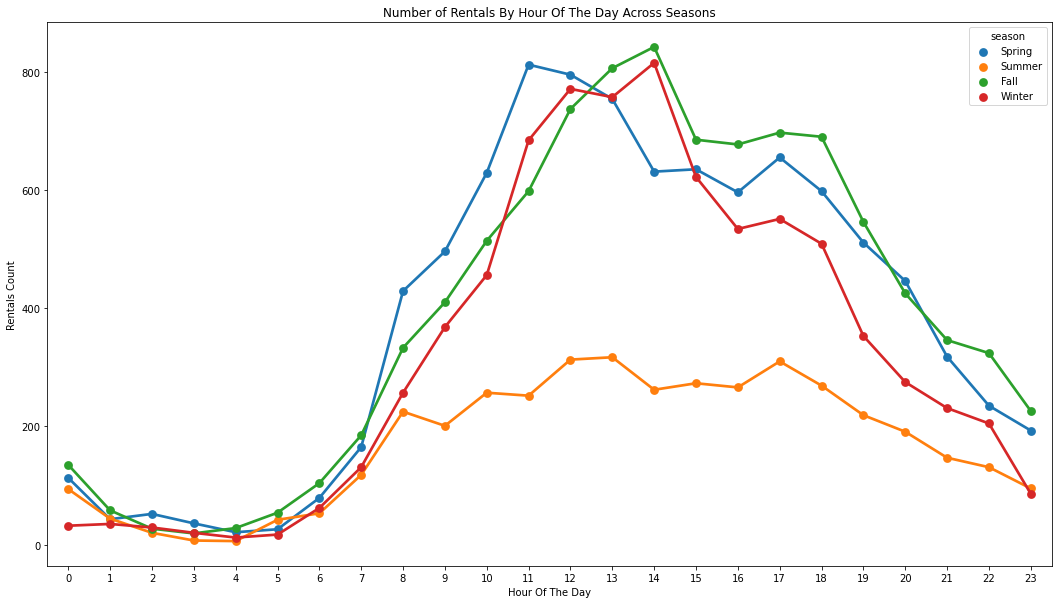

In [217]:
# 0 - Spring | 1 - Summer | 2 - Autumn | 3 - Winter
season_map = {0:'Spring', 1:'Summer', 2:'Fall', 3:'Winter'}
season_freq = hourly_data.groupby(['season', 'rental_hour'])['count'].agg('sum').reset_index(name='count')
season_freq['season'] = season_freq['season'].map(lambda d : season_map[d])
fig, ax = plt.subplots(figsize=(18, 10))
sns.pointplot(x=season_freq["rental_hour"], y=season_freq["count"], hue=season_freq["season"], ax=ax)
ax.set(xlabel='Hour Of The Day', ylabel='Rentals Count', title="Number of Rentals By Hour Of The Day Across Seasons")
plt.show()

### Note

Summer data is very low due to the last data collect is July 30th and the summer have just started. **Decided to not use the season as a predictor** for now and after the changing of season the model will be rebuild adding this feature.

### Rentals by Days of the Week

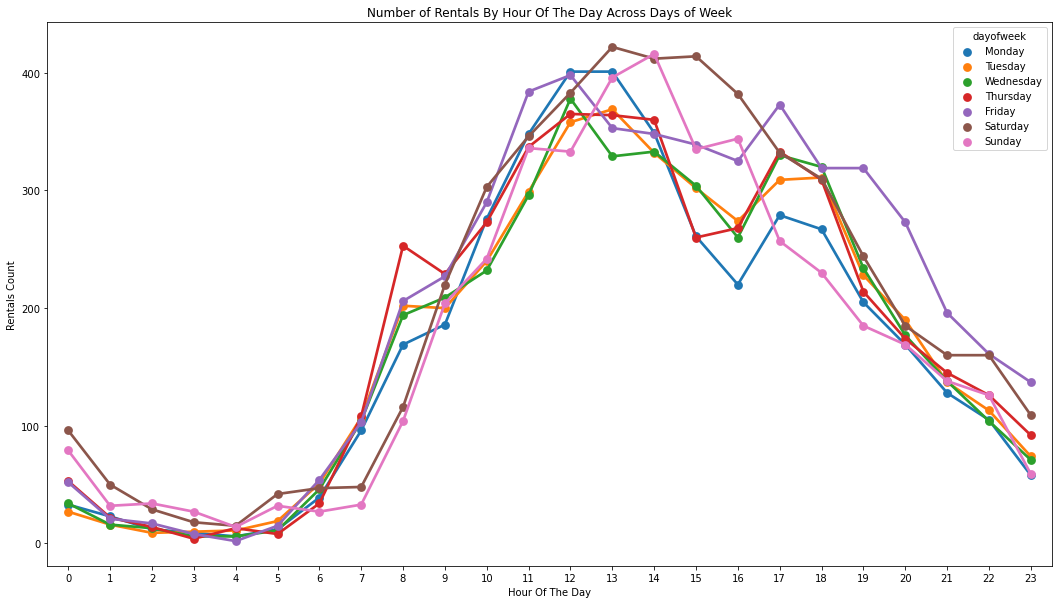

In [183]:
day_of_week_map = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
day_of_week = hourly_data.groupby(['dayofweek', 'rental_hour'])['count'].agg('sum').reset_index(name='count')
day_of_week['dayofweek'] = day_of_week['dayofweek'].map(lambda d : day_of_week_map[d])
fig, ax = plt.subplots(figsize=(18, 10))
sns.pointplot(x=day_of_week["rental_hour"], y=day_of_week["count"], hue=day_of_week["dayofweek"], ax=ax)
ax.set(xlabel='Hour Of The Day', ylabel='Rentals Count', title="Number of Rentals By Hour Of The Day Across Days of Week")
plt.show()

In [184]:
battery_dist = all_data.copy()

def group_battery_status(df):

    bins= [0,30,50,80,100]
    labels = ['< 30%','30% - 50%','50% - 80%','> 80%']
    battery_dist['battery_status'] = pd.cut(battery_dist['start_battery'], bins=bins, labels=labels, right=False)

    s = battery_dist.battery_status
    counts = s.value_counts()
    percent = s.value_counts(normalize=True)
    percent100 = s.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
    
    return pd.DataFrame({'counts': counts, 'per': percent, 'per100': percent100}, labels)

In [185]:
group_battery_status(battery_dist)

,counts,per,per100
< 30%,3271,0.108841,10.9%
30% - 50%,5116,0.170233,17.0%
50% - 80%,12226,0.406815,40.7%
> 80%,9440,0.314112,31.4%


<AxesSubplot:xlabel='start_battery', ylabel='Count'>

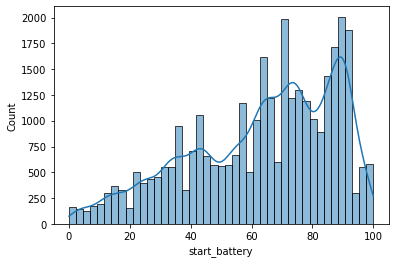

In [186]:
sns.histplot(data=new_rentals, x='start_battery', kde=True)

In [187]:
all_data['duration'].mean()

1045.4229848069792

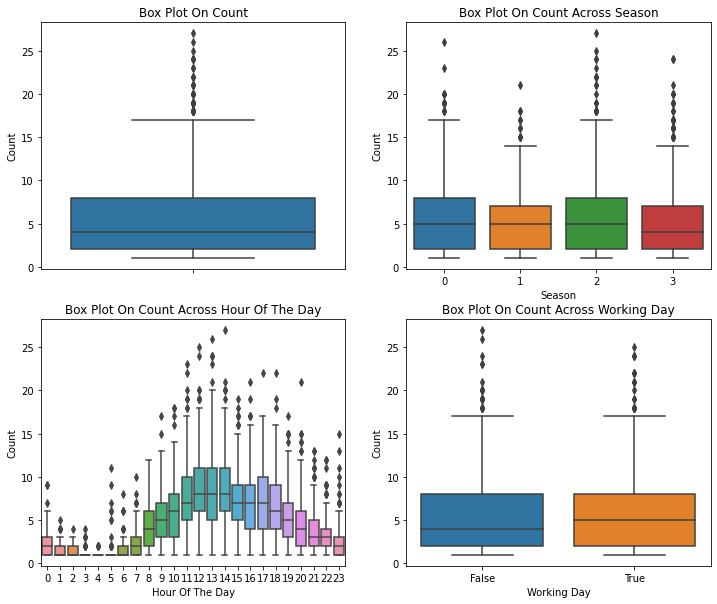

In [188]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=hourly_data,y="count",orient="v",ax=axes[0][0])
sns.boxplot(data=hourly_data,y="count",x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=hourly_data,y="count",x="rental_hour",orient="v",ax=axes[1][0])
sns.boxplot(data=hourly_data,y="count",x="working_day",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

plt.show()

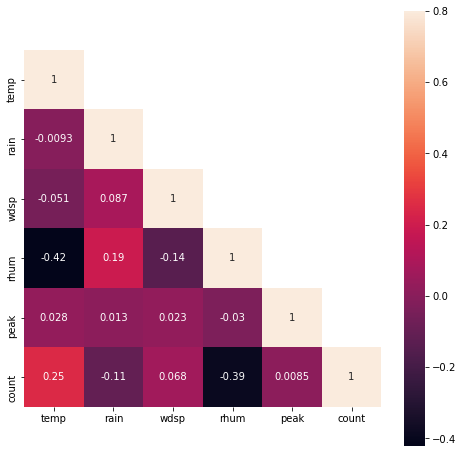

In [189]:
corrMatt = hourly_data[['temp','rain','wdsp','rhum','peak','count']].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(8,8)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)
plt.show()

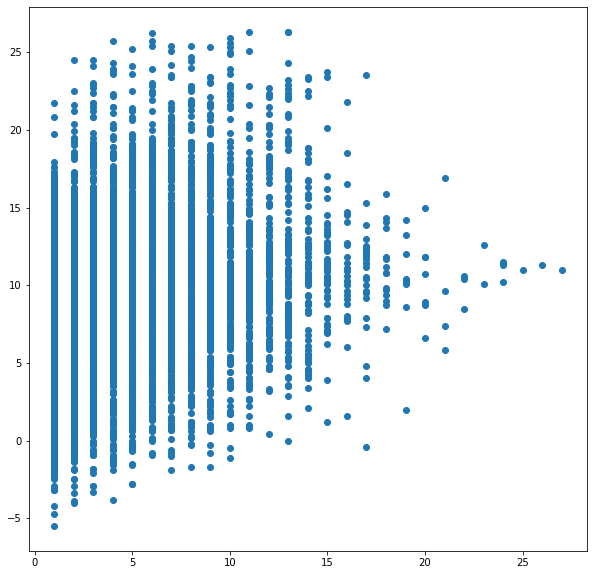

In [190]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(hourly_data['count'], hourly_data['temp'])

plt.show()

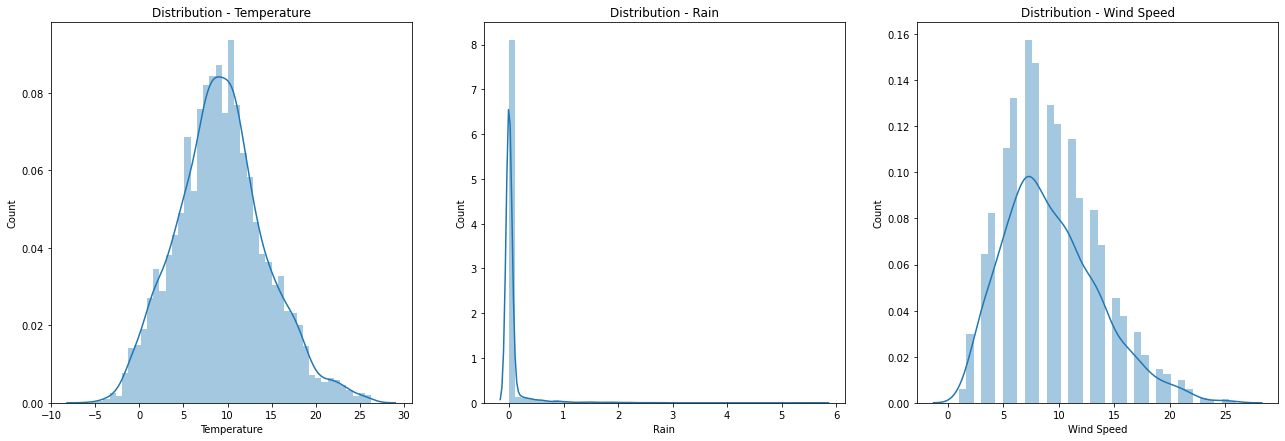

In [191]:
fig = plt.figure(figsize=(22,7))
gs = fig.add_gridspec(1, 3)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])

sns.distplot(hourly_data['temp'],ax=ax0)
sns.distplot(hourly_data['rain'],ax=ax1)
sns.distplot(hourly_data['wdsp'],ax=ax2)

ax0.set(xlabel='Temperature',ylabel='Count',title="Distribution - Temperature")
ax1.set(xlabel='Rain', ylabel='Count',title="Distribution - Rain")
ax2.set(xlabel='Wind Speed', ylabel='Count',title="Distribution - Wind Speed")

plt.show()

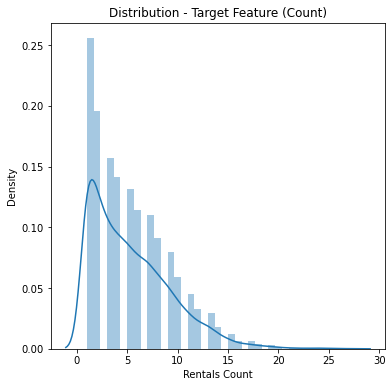

In [192]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.distplot(hourly_data['count'],ax=ax)
ax.set(xlabel='Rentals Count',ylabel='Density',title="Distribution - Target Feature (Count)")
plt.show()

In [193]:
transform_data = hourly_data.copy()
transform_data['count'] = np.log(transform_data['count'] + 1)

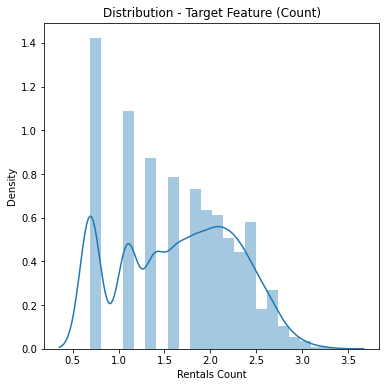

In [194]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.distplot(transform_data['count'],ax=ax)
ax.set(xlabel='Rentals Count',ylabel='Density',title="Distribution - Target Feature (Count)")
plt.show()

## Outliers Analysis

In [195]:
hourlyDataWithoutOutliers = hourly_data[np.abs(hourly_data["count"]-hourly_data["count"].mean())<=(3*hourly_data["count"].std())] 

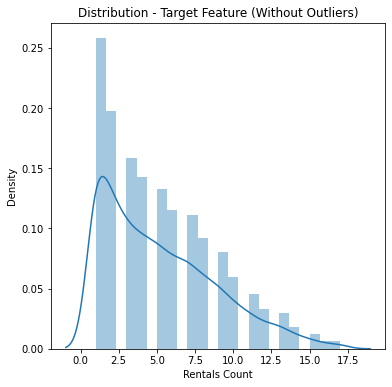

In [196]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.distplot(hourlyDataWithoutOutliers['count'],ax=ax)
ax.set(xlabel='Rentals Count',ylabel='Density',title="Distribution - Target Feature (Without Outliers)")
plt.show()

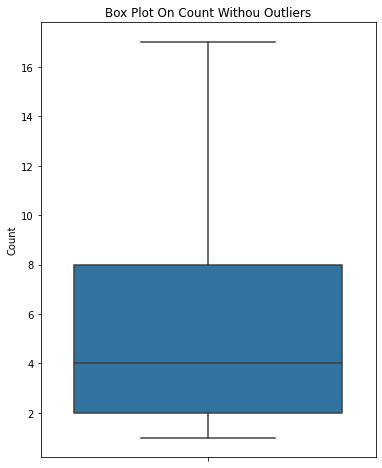

In [197]:
fig, ax = plt.subplots(figsize=(6, 8))
sns.boxplot(data=hourlyDataWithoutOutliers,y="count",orient="v",ax=ax)
ax.set(ylabel='Count',title="Box Plot On Count Withou Outliers")
plt.show()

In [198]:
print ("Shape of original data: ",hourly_data.shape)
print ("Shape of data without outliers: ",hourlyDataWithoutOutliers.shape)

Shape of original data:  (5730, 12)
Shape of data without outliers:  (5680, 12)


<a id="4"></a>
# <p style="font-size:100%; text-align:left; color:#444444;">4- Models</p>

## Splitting dataset in train and test

In [199]:
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models & Evaluation
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn.linear_model import ElasticNet
from sklearn import metrics

In [200]:
def adjusted_r2_score(X, r2_score):
    return 1 - ( 1- r2_score ) * ( len(X) - 1 ) / ( len(X) - X.shape[1] - 1 )

In [201]:
#df = hourly_data.copy()
#df = hourlyDataWithoutOutliers.copy()
df = transform_data.copy()
df = df.astype({'holiday': 'category', 'dayofweek': 'category', 'working_day': 'category', 'peak': 'category'})
predictors = ['rain','temp','wdsp','rhum','holiday','dayofweek','working_day','peak']

X = df[[c for c in df.columns if c in predictors]]
y = df.pop('count')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((4011, 8), (1719, 8))

## Split columns in categorical and numerical

In [202]:
num_vars = [c for c in df.select_dtypes(include=['number']).columns if c in predictors] # list comprehension to select only predictors features
cat_vars = df.select_dtypes(include=['category']).columns

## Preprocessing Pipelines

In [203]:
# Define categorical pipeline
cat_pipe = Pipeline([
    #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Define numerical pipeline
num_pipe = Pipeline([
    #('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_vars),
    ('num', num_pipe, num_vars)
])

## Linear Regression

In [204]:
pipe_linear_regression = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])
pipe_linear_regression.fit(X_train, y_train)

# Predict training data
y_train_pred = pipe_linear_regression.predict(X_train)

# Predict test data
y_test_pred = pipe_linear_regression.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

Root Mean Squared Error: 0.5713963266385552
R^2: 0.17639628260633455
Adjusted R^2: 0.17254316579981444


## Ridge Regression

[Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) regression addresses some of the problems of Ordinary Least Squares by imposing a penalty on the size of the coefficients with l2 regularization.

In [205]:
# Fit a pipeline with transformers and an estimator to the training data
pipe_ridge = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Ridge())
])
pipe_ridge.fit(X_train, y_train)

y_train_pred = pipe_ridge.predict(X_train)
y_test_pred = pipe_ridge.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

Root Mean Squared Error: 0.5706061309515988
R^2: 0.1786726643994777
Adjusted R^2: 0.17483019733234073


## Lasso Regression

The [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso) is a linear model that estimates sparse coefficients with l1 regularization.

In [206]:
# Fit a pipeline with transformers and an estimator to the training data
pipe_lasso = Pipeline([
    ('preprocessor', preprocessor),
    ('model', linear_model.Lasso(alpha=0.1))
])
pipe_lasso.fit(X_train, y_train)
y_train_pred = pipe_lasso.predict(X_train)
y_test_pred = pipe_lasso.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

Root Mean Squared Error: 0.5848325443166369
R^2: 0.1372072763738894
Adjusted R^2: 0.13317081918733453


## Elastic-Net

[Elastic-Net](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet) is a linear regression model trained with both l1 and l2 -norm regularization of the coefficients.

In [207]:
# Fit a pipeline with transformers and an estimator to the training data
pipe_elastic = Pipeline([
    ('preprocessor', preprocessor),
    ('model', ElasticNet())
])
pipe_elastic.fit(X_train, y_train)
y_train_pred = pipe_elastic.predict(X_train)
y_test_pred = pipe_elastic.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

Root Mean Squared Error: 0.6296224501000915
R^2: -8.796020657619863e-06
Adjusted R^2: -0.004687199744730863


In [208]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

## Random Forest Regressor

In [209]:
# random forest model
params_rf = {'n_estimators': 1000, 'max_depth': 15, 'random_state': 0, 'min_samples_split' : 5, 'n_jobs': -1}

# Fit a pipeline with transformers and an estimator to the training data
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(**params_rf))
])
pipe_rf.fit(X_train, y_train)
y_train_pred = pipe_rf.predict(X_train)
y_test_pred = pipe_rf.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

Root Mean Squared Error: 0.5646423336055234
R^2: 0.1957514588072875
Adjusted R^2: 0.19198889253270168


## GradientBoost

In [210]:
# GBM model
params_gbm = {'n_estimators': 150, 'max_depth': 5, 'random_state': 0, 'min_samples_leaf' : 10, 'learning_rate': 0.01, 'subsample': 0.7, 'loss': 'ls'}

# Fit a pipeline with transformers and an estimator to the training data
pipe_gbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(**params_gbm))
])
pipe_gbm.fit(X_train, y_train)
y_train_pred = pipe_gbm.predict(X_train)
y_test_pred = pipe_gbm.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

Root Mean Squared Error: 0.5646173613021976
R^2: 0.19582259585529438
Adjusted R^2: 0.19206036238561153


## LightGBM

In [211]:
# LightGBM model
params_lightgbm = {'n_estimators': 150, 'max_depth': 5, 'random_state': 0, 'learning_rate': 0.01, 'subsample': 0.7}

# Fit a pipeline with transformers and an estimator to the training data
pipe_gbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(**params_lightgbm))
])
pipe_gbm.fit(X_train, y_train)
y_train_pred = pipe_gbm.predict(X_train)
y_test_pred = pipe_gbm.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

Root Mean Squared Error: 0.5654051782284016
R^2: 0.19357687473502816
Adjusted R^2: 0.18980413496770665


## Catboost

In [212]:
# Catboost model

# Fit a pipeline with transformers and an estimator to the training data
pipe_catboost = Pipeline([
    ('preprocessor', preprocessor),
    ('model', CatBoostRegressor(verbose=0, n_estimators=100))
])
pipe_catboost.fit(X_train, y_train)
y_train_pred = pipe_catboost.predict(X_train)
y_test_pred = pipe_catboost.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('R^2:', metrics.r2_score(y_test, y_test_pred))
print('Adjusted R^2:', adjusted_r2_score(X_test, metrics.r2_score(y_test, y_test_pred)))

Root Mean Squared Error: 0.5621104361910826
R^2: 0.20294790611105618
Adjusted R^2: 0.19921900742619558


<img title="GitHub Mark" src="./img/GitHub-Mark-64px.png" style="height: 32px; padding-right: 15px" alt="GitHub Mark" align="left"> [GitHub repository](https://github.com/pessini/moby-bikes) <br>Author: Leandro Pessini